# 数据说明
在Pima Indians Diabetes Data Set（皮马印第安人糖尿病数据集）进行分类模型训练，数据集只有一个文件（diabetes.csv）：Pima Indians Diabetes Dataset 包括根据医疗记录的比马印第安人5 年内糖尿病的发病情况，这是一个两类分类问题。每个类的样本数目数量不均等。一共有 768 个样本，每个样本有8 个输入变量和1 个输出变量。缺失值通常用零值编码。

1) 字段说明  
    Pregnancies： 怀孕次数  
    Glucose： 口服葡萄糖耐受试验中，2 小时的血浆葡萄糖浓度。  
    BloodPressure： 舒张压（mm Hg）  
    SkinThickness： 三头肌皮肤褶层厚度（mm）  
    Insulin：2 小时血清胰岛素含量（μU/ ml）  
    BMI： 体重指数（体重，kg /（身高，m）^ 2）  
2) DiabetesPedigreeFunction： 糖尿病家族史  
3) Age： 年龄（岁）  
    Outcome： 输出变了/类别标签（0 或 1，出现糖尿病为1, 否则为 0）  

## 导入必要工具包

In [84]:
import pandas as pd 
import numpy as np

from sklearn.model_selection import GridSearchCV

#竞赛的评价指标为logloss
#from sklearn.metrics import log_loss  
#SVM并不能直接输出各类的概率，所以在这个例子中我们用正确率作为模型预测性能的度量
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

## 读取数据 & 数据探索

In [85]:
# 读取数据
data = pd.read_csv("diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [86]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [87]:
# 各属性统计特征
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


从数据的大致取值可以看出，数据没有做脱敏处理，有单位和具体的物理含义，train.info虽然显示没有缺失值，但有些特征数据明显不对，如舒张压和体重等特征都不应该存在零值，（舒张压为0是说明这个人已经挂了么，体重身高比为0[捂脸]）应该是存在缺失值，但直接使用了零值进行填充，

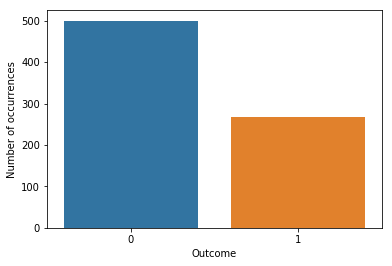

In [88]:
# Target 分布，看看各类样本分布是否均衡
sns.countplot(data.Outcome);
pyplot.xlabel('Outcome');
pyplot.ylabel('Number of occurrences');

分类结果中正例的样本约为反例样本的一半多一些，样本不均衡，交叉验证对分类任务缺省的是采用StratifiedKFold，在每折采样时根据各类样本按比例采样

## 数据准备

In [89]:
data = data.drop('SkinThickness', axis=1)
data = data.drop('Insulin', axis=1)

data.shape

(768, 7)

三头肌皮肤褶层厚度和血清胰岛素两个特征为0值的样本数太多，但不确定是否去除之后更合理些，通过后续模型训练，分别尝试去除看效果如何

In [90]:
for i in range(768):
    if data.Glucose.values[i] == 0:
        data.Glucose.values[i] = 117
    if data.BloodPressure.values[i] == 0:
        data.BloodPressure.values[i] = 72
    if data.BMI.values[i] == 0:
        data.BMI.values[i] = 32
        
data.shape

(768, 7)

从特征工程可看出，有三个特征（血浆葡萄糖浓度、舒张压、体重指数）对应的样本数据存在少部分缺失，其中零值即为缺失值，使用对应特征的中位数进行替换填充，由于读取的数据文件缺失值使用了零值编码，而不是直接空着，无法使用sklearn.preprocessing.Imputer进行填充，故使用循环判断的方式进行填充 

其中中位数如下：  
Glucose ：117  
BloodPressure ：72  
BMI ：32  

In [91]:
# 从原始数据中分离输入特征x和输出y
y = data['Outcome'].values
X = data.drop('Outcome', axis = 1)

In [92]:
#将数据分割训练数据与测试数据
from sklearn.model_selection import train_test_split

# 随机采样20%的数据构建测试样本，其余作为训练样本
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.2)
X_train.shape

(614, 6)

In [93]:
X_train = np.array(X_train)
X_test = np.array(X_test)

## 数据预处理

In [94]:
# 数据标准化
from sklearn.preprocessing import StandardScaler

# 初始化特征的标准化器
ss_X = StandardScaler()

# 分别对训练和测试数据的特征进行标准化处理
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

## 模型训练

### SVM（训练中增加权重参数）

In [95]:
def LinearSVC_performance(C, X_train, y_train, X_test, y_test):
    
    # 在训练集是那个利用SVC训练
    SVC2 =  LinearSVC(C = C, class_weight={0:0.3489, 1:0.6511})
    SVC2 = SVC2.fit(X_train, y_train)
    
    # 在校验集上返回accuracy
    accuracy = SVC2.score(X_test, y_test)
    
    print("accuracy: {}".format(accuracy))
    return accuracy

定义模型性能最终评估函数，在测试集上使用训练得到的LinearSVC（包含已确定的参数C）进行数据分类，并返回正确率

### 1 default SVC

由于LinerSVC是基于libliner实现的SVM的，而SVC/NuSVC是基于libsvm实现的，所以如果核函数想采用的线性核，linerSVC的训练效率更高一点，且可以有更多正则选择（L1/L2）和损失函数选择

In [96]:
from sklearn.svm import LinearSVC

SVC1_train = LinearSVC(class_weight={0:0.3489, 1:0.6511})

因为数据探索时发现，样本在分类时，0类别比1类别多很多，所以在训练时，加上class_weight权重，让模型训练更合理些

In [97]:
from sklearn.cross_validation import cross_val_score
accuracy = cross_val_score(SVC1_train, X_train, y_train, cv=5, scoring='accuracy')
print('accuracy of each fold is: ',accuracy)
print('cv accuracy is:', accuracy.mean())

accuracy of each fold is:  [0.76612903 0.72357724 0.7804878  0.81967213 0.71311475]
cv accuracy is: 0.7605961916308746


由于本数据集的样本数只有768个，数据量不大，使用交叉验证得出模型在训练集上的正确率比较合适  
上述结果得出，缺省参数（C = 1.0）的LinearSVC模型训练后，在训练集上的准确率为 0.7605961916308746

In [98]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#使用训练集训练出模型，并在测试集上看模型预测的情况
SVC1 = LinearSVC(class_weight={0:0.3489, 1:0.6511}).fit(X_train, y_train)
y_predict = SVC1.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (SVC1, classification_report(y_test, y_predict)))
print("Confusion matrix:\n%s" % confusion_matrix(y_test, y_predict))

Classification report for classifier LinearSVC(C=1.0, class_weight={0: 0.3489, 1: 0.6511}, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0):
             precision    recall  f1-score   support

          0       0.80      0.83      0.82        99
          1       0.67      0.64      0.65        55

avg / total       0.76      0.76      0.76       154


Confusion matrix:
[[82 17]
 [20 35]]


对角线参数表示分正确的数目

In [99]:
default_SVC_accuracy = LinearSVC_performance(1.0, X_train, y_train, X_test, y_test)
print('default SVC accuracy on test data:', default_SVC_accuracy)

accuracy: 0.7597402597402597
default SVC accuracy on test data: 0.7597402597402597


缺省参数（C = 1.0）的LinearSVC模型训练后，在测试集上的准确率为 0.7597402597402597，比训练集略低一点点

### 2 线性SVM正则参数调优

In [100]:
from sklearn.model_selection import GridSearchCV
#Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#penaltys = ['l1','l2']
Cs = np.logspace(-3, 3, 7)
tuned_parameters = dict(C = Cs)

SVC3 = LinearSVC(class_weight={0:0.3489, 1:0.6511})
grid= GridSearchCV(SVC3, tuned_parameters,cv=5, scoring='accuracy')
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight={0: 0.3489, 1: 0.6511}, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

因为样本数量不大，这边直接使用GridSearchCV对不同候选参数C进行训练

In [101]:
grid.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

{'mean_fit_time': array([0.00100074, 0.00140028, 0.00360222, 0.01340714, 0.03602319,
        0.03502364, 0.03602395]),
 'mean_score_time': array([0.00060081, 0.00080099, 0.00040035, 0.00020051, 0.00020008,
        0.00020037, 0.00040026]),
 'mean_test_score': array([0.72638436, 0.76710098, 0.75895765, 0.76058632, 0.76058632,
        0.75081433, 0.6514658 ]),
 'mean_train_score': array([0.72597855, 0.75774223, 0.76670024, 0.76792224, 0.7675149 ,
        0.76872528, 0.64939249]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0},
  {'C': 1000.0}],
 'rank_test_score': array([6, 1, 4, 2, 2, 5, 7]),
 'split0_test_score': array([0.74193548, 0.75806452, 0.76612903, 0.76612903, 0.76612903,
        0.74193548, 0.56451613]),
 'split0_train_score': array

In [102]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.7671009771986971
{'C': 0.01}


In [103]:
best_SVC_accuracy = LinearSVC_performance(0.01, X_train, y_train, X_test, y_test)
print('default SVC accuracy on test data:', best_SVC_accuracy)

accuracy: 0.7662337662337663
default SVC accuracy on test data: 0.7662337662337663


发现最佳的参数 C 最优取值是 0.01，此时在训练集上得到的正确率是0.757328990228013，和上面直接做缺省参数LinearSVC得到的准确率差不多  
第一次 缺省参数LinearSVC 训练集上正确率：0.7605961916308746  测试集上正确率：0.7597402597402597  
第二次 参数调优LinearSVC 训练集上正确率：0.7671009771986971  测试集上正确率： 0.7662337662337663  

在选出最优参数C=0.01后，训练的效果比默认参数C=1好，在训练集和测试集上的正确率均有所提升

### 3 RBF核SVM正则参数调优

In [104]:
from sklearn.svm import SVC

In [105]:
def SVC_performance(C, gamma, X_train, y_train, X_test, y_test):
    
    # 在训练集是那个利用SVC训练
    SVC4 =  SVC(C = C, kernel='rbf', gamma = gamma, class_weight={0:0.3489, 1:0.6511})
    SVC4 = SVC4.fit(X_train, y_train)
    
    # 在校验集上返回accuracy
    accuracy = SVC4.score(X_test, y_test)
    
    print("accuracy: {}".format(accuracy))
    return accuracy

定义模型性能最终评估函数，在测试集上使用训练得到的SVC（包含最优参数C，gamma）进行数据分类，并返回正确率

In [106]:
from sklearn.model_selection import GridSearchCV

C_s = np.logspace(-4, 4, 9)
gamma_s = np.logspace(-4, 4, 9) 
#C_s = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
#gamma_s = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_parameters = dict(gamma = gamma_s, C = C_s)

SVC5 = SVC(class_weight={0:0.3489, 1:0.6511})
grid= GridSearchCV(SVC5, tuned_parameters,cv=5, scoring='accuracy')
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight={0: 0.3489, 1: 0.6511}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]), 'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [107]:
# view the complete results (list of named tuples)
grid.cv_results_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

{'mean_fit_time': array([0.01560941, 0.0130085 , 0.0130084 , 0.01280861, 0.01300793,
        0.0172122 , 0.02161441, 0.02381539, 0.02321548, 0.01300859,
        0.01300845, 0.01300802, 0.01300921, 0.01300864, 0.01701083,
        0.02201481, 0.02341633, 0.02301574, 0.01300864, 0.01300735,
        0.01300879, 0.01300869, 0.01300864, 0.01701045, 0.02181411,
        0.02341518, 0.02341523, 0.01300864, 0.0128087 , 0.01300859,
        0.01160698, 0.01300821, 0.01801271, 0.02261524, 0.02381592,
        0.02381601, 0.01300874, 0.01280861, 0.01000681, 0.0092062 ,
        0.01220822, 0.01761179, 0.02381577, 0.02501645, 0.02521672,
        0.01300845, 0.00960536, 0.00920587, 0.01000686, 0.01581025,
        0.02641754, 0.02881894, 0.02901859, 0.02901902, 0.00980668,
        0.00940585, 0.01020751, 0.0198132 , 0.01781154, 0.02981882,
        0.02801809, 0.02901864, 0.02941909, 0.00960693, 0.01100736,
        0.02661762, 0.09546256, 0.01961188, 0.02801681, 0.02961969,
        0.03122101, 0.02961912,

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


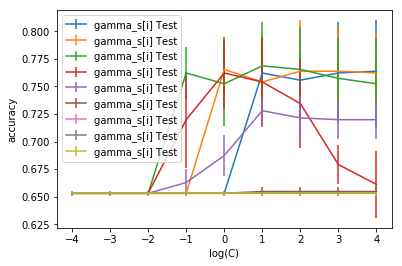

In [113]:
# plot CV误差曲线
test_means = grid.cv_results_[ 'mean_test_score' ]
test_stds = grid.cv_results_[ 'std_test_score' ]
train_means = grid.cv_results_[ 'mean_train_score' ]
train_stds = grid.cv_results_[ 'std_train_score' ]


# plot results
n_Cs = len(C_s)
n_gamma_s = len(gamma_s)
test_scores = np.array(test_means).reshape(n_Cs,n_gamma_s)
train_scores = np.array(train_means).reshape(n_Cs,n_gamma_s)
test_stds = np.array(test_stds).reshape(n_Cs,n_gamma_s)
train_stds = np.array(train_stds).reshape(n_Cs,n_gamma_s)

x_axis = np.log10(C_s)
for i, value in enumerate(gamma_s):
    #pyplot.plot(log(Cs), test_scores[i], label= 'penalty:'   + str(value))
    pyplot.errorbar(x_axis, test_scores[:,i], yerr=test_stds[:,i] ,label = 'gamma_s[i]' +' Test')
    #pyplot.errorbar(x_axis, train_scores[:,i], yerr=train_stds[:,i] ,label = 'gamma_s[i]' +' Train')
    
pyplot.legend()
pyplot.xlabel( 'log(C)' )                                                                                                      
pyplot.ylabel( 'accuracy' )
pyplot.savefig('LogisticGridSearchCV_C.png' )

pyplot.show()

In [109]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.7687296416938111
{'C': 10.0, 'gamma': 0.01}


In [110]:
best_rbfSVM_accuracy = SVC_performance(10.0, 0.01, X_train, y_train, X_test, y_test)

accuracy: 0.7727272727272727


两个参数组合比较多，所以图看起来比较乱，但可以直接得出最优参数  
最终得到的最优参数为 C=10.0，gamma=0.01  
在测试集上的正确率为0.7727272727272727，比线性核的最优参数所训练出来的模型在测试集（0.7662337662337663）上的正确率高

### 数据整理与对比

1、根据api调用，其实class_weight是有自己的备选参数的，{dict, ‘balanced’，None}，也可以根据自己的比例计算，手动设置参数，balanced参数应该是模型自己计算并进行自适应，因为本数据集的样本分类不均衡，尝试过balanced参数，并进行结果对比，发现  

分类的效果 ： 手动设置比例 > 设置为balanced > 不设置参数   

注：根据计算的比例[0:0.3489, 1:0.6511]，在训练集和测试集中跑的效果都不错，比例改为[0:0.4 , 1:0.6]，在训练集上效果更好，但测试集上效果差点，最终选择第一个比例

2、三头肌皮肤褶层厚度和血清胰岛素两个特征的0值太多了，物理含以上我认为应该去掉三头肌皮肤的特征，保留血清胰岛素特征，但实际操作中还是进行对比，并查看训练效果再决定

#### 1)保留 Insulin 和 SkinThickness 两个特征

default LinearSVC( C=1 )--train accuracy: 0.7524658953622853  
default LinearSVC( C=1 )--test accuracy: 0.7597402597402597  

best LinearSVC( C=0.01 )--train accuracy: 0.758957654723127  
best LinearSVC( C=0.01 )--test accuracy:  0.7597402597402597

best rbfSVC( C=1000.0,gamma=0.01 )--train accuracy: 0.7671009771986971  
best rbfSVC( C=1000.0,gamma=0.01 )--test accuracy: 0.7662337662337663  

#### 2)保留 Insulin 特征，去除 SkinThickness 特征 

default LinearSVC( C=1 )--train accuracy: 0.7573310460761932    
default LinearSVC( C=1 )--test accuracy: 0.7532467532467533   

best LinearSVC( C=0.01 )--train accuracy: 0.7638436482084691  
best LinearSVC( C=0.01 )--test accuracy: 0.7597402597402597  

best rbfSVC( C=10.0, gamma=0.01 )--train accuracy: 0.7654723127035831   
best rbfSVC( C=10.0, gamma=0.01 )--test accuracy: 0.7662337662337663  

#### 3)保留 SkinThickness 特征，去除 Insulin 特征 

default LinearSVC(C=1)--train accuracy: 0.7589568473685795  
default LinearSVC(C=1)--test accuracy: 0.7532467532467533  

best LinearSVC( C=0.01 )--train accuracy: 0.762214983713355  
best LinearSVC( C=0.01 )--test accuracy: 0.7597402597402597  

best rbfSVC( C=0.1, gamma=0.01 )--train accuracy: 0.7671009771986971
best rbfSVC( C=0.1, gamma=0.01 )--test accuracy: 0.7012987012987013

#### 4)去除Insulin 和 SkinThickness 两个特征 

default LinearSVC(C=1)--train accuracy: 0.7605961916308746  
default LinearSVC(C=1)--test accuracy: 0.7597402597402597

best LinearSVC( C=0.01 )--train accuracy: 0.7671009771986971  
best LinearSVC( C=0.01 )--test accuracy: 0.7662337662337663  

best rbfSVC( C=10.0, gamma=0.01 )--train accuracy: 0.7687296416938111  
best rbfSVC( C=10.0, gamma=0.01 )--test accuracy: 0.7727272727272727

从以上结果来看，去除Insulin 和 SkinThickness 两个特征，不管在线性核还是RBF核，不管在训练集还是测试集，基本上都比其他的训练效果好，故应去除这两个特征。另外可看出，RBF核训练处的模型比线性核的训练模型预测效果更好，而对比logistic回归可发现，SVM训练的模型预测效果更好一些。